In [24]:
import os
import sys
import json
import pandas as pd
from glob import glob
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [25]:
from __future__ import print_function, division
import numpy as np
import scipy.optimize
import mdtraj as md
from mdtraj.utils import ensure_type

In [26]:
from tmtools import tm_align

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
def my_tm_align(coords1, coords2):
    return tm_align(coords1, coords2, "x"*coords1.shape[0], "x"*coords2.shape[0])

In [29]:
def get_similarity_score(path1, path2, chain1, chain2):
    pdb1 = md.load(path1)
    pdb2 = md.load(path2)
    chain_id_to_index1 = {}
    for chain in pdb1.topology.chains:
        if chain.chain_id not in chain_id_to_index1:
            chain_id_to_index1[chain.chain_id] = chain.index
    CAs1 = pdb1.topology.select(f'name CA and chainid {chain_id_to_index1[chain1]}')
    pdb1_CAs = pdb1.atom_slice(CAs1)
    chain_id_to_index2 = {}
    for chain in pdb2.topology.chains:
        if chain.chain_id not in chain_id_to_index2:
            chain_id_to_index2[chain.chain_id] = chain.index
    CAs2 = pdb2.topology.select(f'name CA and chainid {chain_id_to_index2[chain2]}')
    pdb2_CAs = pdb2.atom_slice(CAs2)
    tm = my_tm_align(pdb1_CAs.xyz.reshape(-1,3)*10, pdb2_CAs.xyz.reshape(-1,3)*10)
    return tm.tm_norm_chain1

In [30]:
def get_similarity_score_local(path1, path2, region1, region2, chain1, chain2):
    pdb1 = md.load(path1)
    pdb2 = md.load(path2)
    chain_id_to_index1 = {}
    for chain in pdb1.topology.chains:
        if chain.chain_id not in chain_id_to_index1:
            chain_id_to_index1[chain.chain_id] = chain.index
    CAs1 = pdb1.topology.select(f'name CA and chainid {chain_id_to_index1[chain1]}')
    CAs1_region = CAs1[region1[0]:region1[1]]
    pdb1_CAs = pdb1.atom_slice(CAs1_region)
    chain_id_to_index2 = {}
    for chain in pdb2.topology.chains:
        if chain.chain_id not in chain_id_to_index2:
            chain_id_to_index2[chain.chain_id] = chain.index
    CAs2 = pdb2.topology.select(f'name CA and chainid {chain_id_to_index2[chain2]}')
    CAs2_region = CAs2[region2[0]:region2[1]]
    pdb2_CAs = pdb2.atom_slice(CAs2_region)
    tm = my_tm_align(pdb1_CAs.xyz.reshape(-1,3)*10, pdb2_CAs.xyz.reshape(-1,3)*10)
    return tm.tm_norm_chain1

### all analogs

In [31]:
# read csv to df
#df = pd.read_csv("/home/zim003/slidingwindow/mysw/prott5_layer24_m06_results.csv")
df = pd.read_csv("/home/zim003/slidingwindow/mysw/baseline_complete_results.csv")
#df = pd.read_csv("/home/zim003/slidingwindow/mysw/prostt5_best_results.csv")
#df = pd.read_csv("/home/zim003/slidingwindow/prostt5/prostt5_complete_results.csv")
df

,pairname,comparison_id,prot1,chain1,prot2,chain2,protein1_residues,protein2_residues
0,d1a05a_-A_183-d1dgsa3-A_184,d1a05a_d1dgsa3,d1a05a_,A,d1dgsa3,A,"(np.int64(118), np.int64(127))","(np.int64(457), np.int64(466))"
1,d1a05a_-A_185-d1j71a_-A_186,d1a05a_d1j71a_,d1a05a_,A,d1j71a_,A,"(np.int64(133), np.int64(149))","(np.int64(254), np.int64(270))"
2,d1a05a_-A_187-d1rblm_-M_188,d1a05a_d1rblm_,d1a05a_,A,d1rblm_,M,"(np.int64(0), np.int64(8))","(np.int64(55), np.int64(63))"
3,d1a2za_-A_0-d1ghha_-A_1,d1a2za_d1ghha_,d1a2za_,A,d1ghha_,A,"(np.int64(86), np.int64(97))","(np.int64(28), np.int64(39))"
4,d1a2za_-A_2-d1u9da_-A_3,d1a2za_d1u9da_,d1a2za_,A,d1u9da_,A,"(np.int64(18), np.int64(28))","(np.int64(108), np.int64(118))"
...,...,...,...,...,...,...,...,...
143,d2gaw.1-A_174-d1nppa1-A_176,d2gaw.1d1nppa1,d2gaw.1,A,d1nppa1,A,"(np.int64(8), np.int64(36))","(np.int64(59), np.int64(87))"
144,d2gaw.1-B_175-d1nppa1-A_176,d2gaw.1d1nppa1,d2gaw.1,B,d1nppa1,A,"(np.int64(82), np.int64(96))","(np.int64(20), np.int64(34))"
145,d2onea1-A_177-d1hz6b_-B_178,d2onea1d1hz6b_,d2onea1,A,d1hz6b_,B,"(np.int64(177), np.int64(183))","(np.int64(23), np.int64(29))"
146,d3pmga1-A_179-d1e8ca1-A_180,d3pmga1d1e8ca1,d3pmga1,A,d1e8ca1,A,"(np.int64(417), np.int64(457))","(np.int64(194), np.int64(234))"


In [32]:
# print the row where pairname is d1g99a1-A_58-d1gqyb3-B_59
print(df[df['pairname'] == 'd1g99a1-A_58-d1gqyb3-B_59'])

                     pairname   comparison_id    prot1 chain1    prot2 chain2  \
41  d1g99a1-A_58-d1gqyb3-B_59  d1g99a1d1gqyb3  d1g99a1      A  d1gqyb3      B   

                 protein1_residues             protein2_residues  
41  (np.int64(309), np.int64(336))  (np.int64(59), np.int64(86))  


In [33]:
id_list = df["comparison_id"].tolist()
region1_list = df["protein1_residues"].tolist()
region2_list = df["protein2_residues"].tolist()
chain1_list = df["chain1"].tolist()
chain2_list = df["chain2"].tolist()

In [34]:
analogs_folder = "/home/zim003/slidingwindow/analogs_complete"

In [35]:
similarity_scores = []
similarity_local_scores = []

for i in [10]:
        id = id_list[i]
        region1 = eval(region1_list[i])
        region2 = eval(region2_list[i])
        pair_folder = os.path.join(analogs_folder, id)
        pair_paths = glob(os.path.join(pair_folder, "*.pdb"))
        #print(pair_paths)
        #print(pair_paths)
        id1, id2 = id[1:5], id[8:12]
        #print(f"Processing pair: {id1}, {id2}")
        path1, path2 = None, None
        for path in pair_paths:
            if id1 in path.split("/")[-1]:
                path1 = path
            elif id2 in path.split("/")[-1]:
                path2 = path
        #print(f"Paths: {path1}, {path2}, Regions: {region1}, {region2}, Chains: {chain1_list[i]}, {chain2_list[i]}")
        similarity = get_similarity_score(path1, path2, chain1_list[i], chain2_list[i])
        print(path1, path2, region1, region2, chain1_list[i], chain2_list[i])
        #similarity_local = get_similarity_score_local(path1, path2, region1, region2, chain1_list[i], chain2_list[i])
        #similarity_scores.append(similarity)
        #similarity_local_scores.append(similarity_local)  

/home/zim003/slidingwindow/analogs_complete/d1ac5__d1vk0a_/1ac5.pdb /home/zim003/slidingwindow/analogs_complete/d1ac5__d1vk0a_/1vk0.pdb (np.int64(238), np.int64(276)) (np.int64(6), np.int64(44)) A A


In [61]:
pdb1 = md.load(path1)
pdb2 = md.load(path2)
pdb1, pdb2

(<mdtraj.Trajectory with 1 frames, 5403 atoms, 744 residues, and unitcells at 0x7f2025fa9480>,
 <mdtraj.Trajectory with 1 frames, 10191 atoms, 1845 residues, and unitcells at 0x7f20176ffdf0>)

In [62]:
chain_id_to_index1 = {}
for chain in pdb1.topology.chains:
    if chain.chain_id not in chain_id_to_index1:
        chain_id_to_index1[chain.chain_id] = chain.index
CAs1 = pdb1.topology.select(f'name CA and chainid {chain_id_to_index1[chain1_list[i]]}')
CAs1_region = CAs1[region1[0]:region1[1]]
pdb1_CAs = pdb1.atom_slice(CAs1_region)
pdb1_CAs

<mdtraj.Trajectory with 1 frames, 31 atoms, 31 residues, and unitcells at 0x7f20176fee60>

In [63]:
chain_id_to_index2 = {}
for chain in pdb2.topology.chains:
    if chain.chain_id not in chain_id_to_index2:
        chain_id_to_index2[chain.chain_id] = chain.index
CAs2 = pdb2.topology.select(f'name CA and chainid {chain_id_to_index2[chain2_list[i]]}')
CAs2_region = CAs2[region2[0]:region2[1]]
pdb2_CAs = pdb2.atom_slice(CAs2_region)
pdb2_CAs

<mdtraj.Trajectory with 1 frames, 31 atoms, 31 residues, and unitcells at 0x7f2024be97b0>

In [64]:
CAs2, len(CAs2)

(array([   1,    7,   12,   18,   29,   37,   41,   48,   57,   68,   77,
          85,   92,  100,  104,  110,  122,  129,  138,  145,  154,  161,
         169,  177,  184,  188,  194,  200,  207,  215,  223,  229,  236,
         248,  256,  262,  270,  278,  289,  298,  306,  312,  320,  328,
         336,  340,  348,  359,  364,  371,  379,  390,  398,  405,  417,
         431,  439,  446,  450,  461,  468,  477,  484,  490,  494,  508,
         514,  522,  528,  534,  541,  550,  558,  564,  571,  582,  590,
         598,  604,  612,  623,  631,  642,  650,  657,  666,  673,  684,
         694,  702,  710,  718,  727,  735,  743,  755,  766,  777,  788,
         793,  799,  808,  819,  826,  833,  844,  851,  855,  862,  871,
         879,  888,  897,  905,  913,  921,  929,  937,  948,  957,  965,
         975,  979,  987,  994, 1002, 1013, 1021, 1026, 1034, 1042, 1049,
        1053, 1062, 1070, 1075, 1080, 1089, 1094, 1105, 1109, 1116, 1124,
        1131, 1139, 1148, 1159, 1167, 

In [65]:
region2, chain2_list[i]

((52, 83), 'A')

In [36]:
similarity_scores = []
similarity_local_scores = []

for i in tqdm(range(len(id_list))):
    try:
        id = id_list[i]
        region1 = eval(region1_list[i])
        region2 = eval(region2_list[i])
        pair_folder = os.path.join(analogs_folder, id)
        pair_paths = glob(os.path.join(pair_folder, "*.pdb"))
        #print(pair_paths)
        #print(pair_paths)
        id1, id2 = id[1:5], id[8:12]
        #print(f"Processing pair: {id1}, {id2}")
        path1, path2 = None, None
        for path in pair_paths:
            if id1 in path.split("/")[-1]:
                path1 = path
            elif id2 in path.split("/")[-1]:
                path2 = path
        #print(f"Paths: {path1}, {path2}, Regions: {region1}, {region2}, Chains: {chain1_list[i]}, {chain2_list[i]}")
        similarity = get_similarity_score(path1, path2, chain1_list[i], chain2_list[i])
        similarity_local = get_similarity_score_local(path1, path2, region1, region2, chain1_list[i], chain2_list[i])
        similarity_scores.append(similarity)
        similarity_local_scores.append(similarity_local)  
    except Exception as e:
        print(f"Error processing {id}: {e}")
        continue

  2%|▏         | 3/148 [00:04<03:34,  1.48s/it]/home/zim003/miniforge3/envs/process/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:208: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(
100%|██████████| 148/148 [02:37<00:00,  1.06s/it]


In [41]:
len(similarity_scores), len(similarity_local_scores)

(148, 148)

In [37]:
for i, score in enumerate(similarity_local_scores):
    if score < 0.1:
        print(f"Index: {i}, Local Similarity Score: {score}, Comparison ID: {id_list[i]}")

Index: 28, Local Similarity Score: 0.03877093538266084, Comparison ID: d1dmza_d1hdha_
Index: 79, Local Similarity Score: 0.045758995097941055, Comparison ID: d1lq7a_d1gqea_
Index: 112, Local Similarity Score: 0.03233797989581919, Comparison ID: d1pqsa_d1i7la2
Index: 113, Local Similarity Score: 0.04671125859525656, Comparison ID: d1pqsa_d1poh__


In [38]:
# count the number of similarity scores that are greater than 0.5 and less than 0.1
count_greater_05 = sum(1 for score in similarity_local_scores if score > 0.5)
count_greater_04 = sum(1 for score in similarity_local_scores if score > 0.4)
count_less_01 = sum(1 for score in similarity_local_scores if score < 0.1)
print(f"Number of local similarity scores greater than 0.5: {count_greater_05}")
print(f"Number of local similarity scores greater than 0.4: {count_greater_04}")
print(f"Number of local similarity scores less than 0.1: {count_less_01}")

Number of local similarity scores greater than 0.5: 25
Number of local similarity scores greater than 0.4: 52
Number of local similarity scores less than 0.1: 4


In [39]:
# print the mean and standard deviation of similarity_local_scores （.3format）(±)
print(f"{np.mean(similarity_local_scores):.3f}±{np.std(similarity_local_scores):.3f}")
# print the mean and standard deviation of similarity_scores （.3format）(±)
print(f"{np.mean(similarity_scores):.3f}±{np.std(similarity_scores):.3f}")

0.356±0.167
0.257±0.110


In [40]:
# maen and std of all length of the regions
lengths = []
for region in region1_list:
    region_eval = eval(region)
    lengths.append(region_eval[1] - region_eval[0])
for region in region2_list:
    region_eval = eval(region)
    lengths.append(region_eval[1] - region_eval[0])
print(f"{np.mean(lengths):.1f}±{np.std(lengths):.1f}")

18.3±11.0


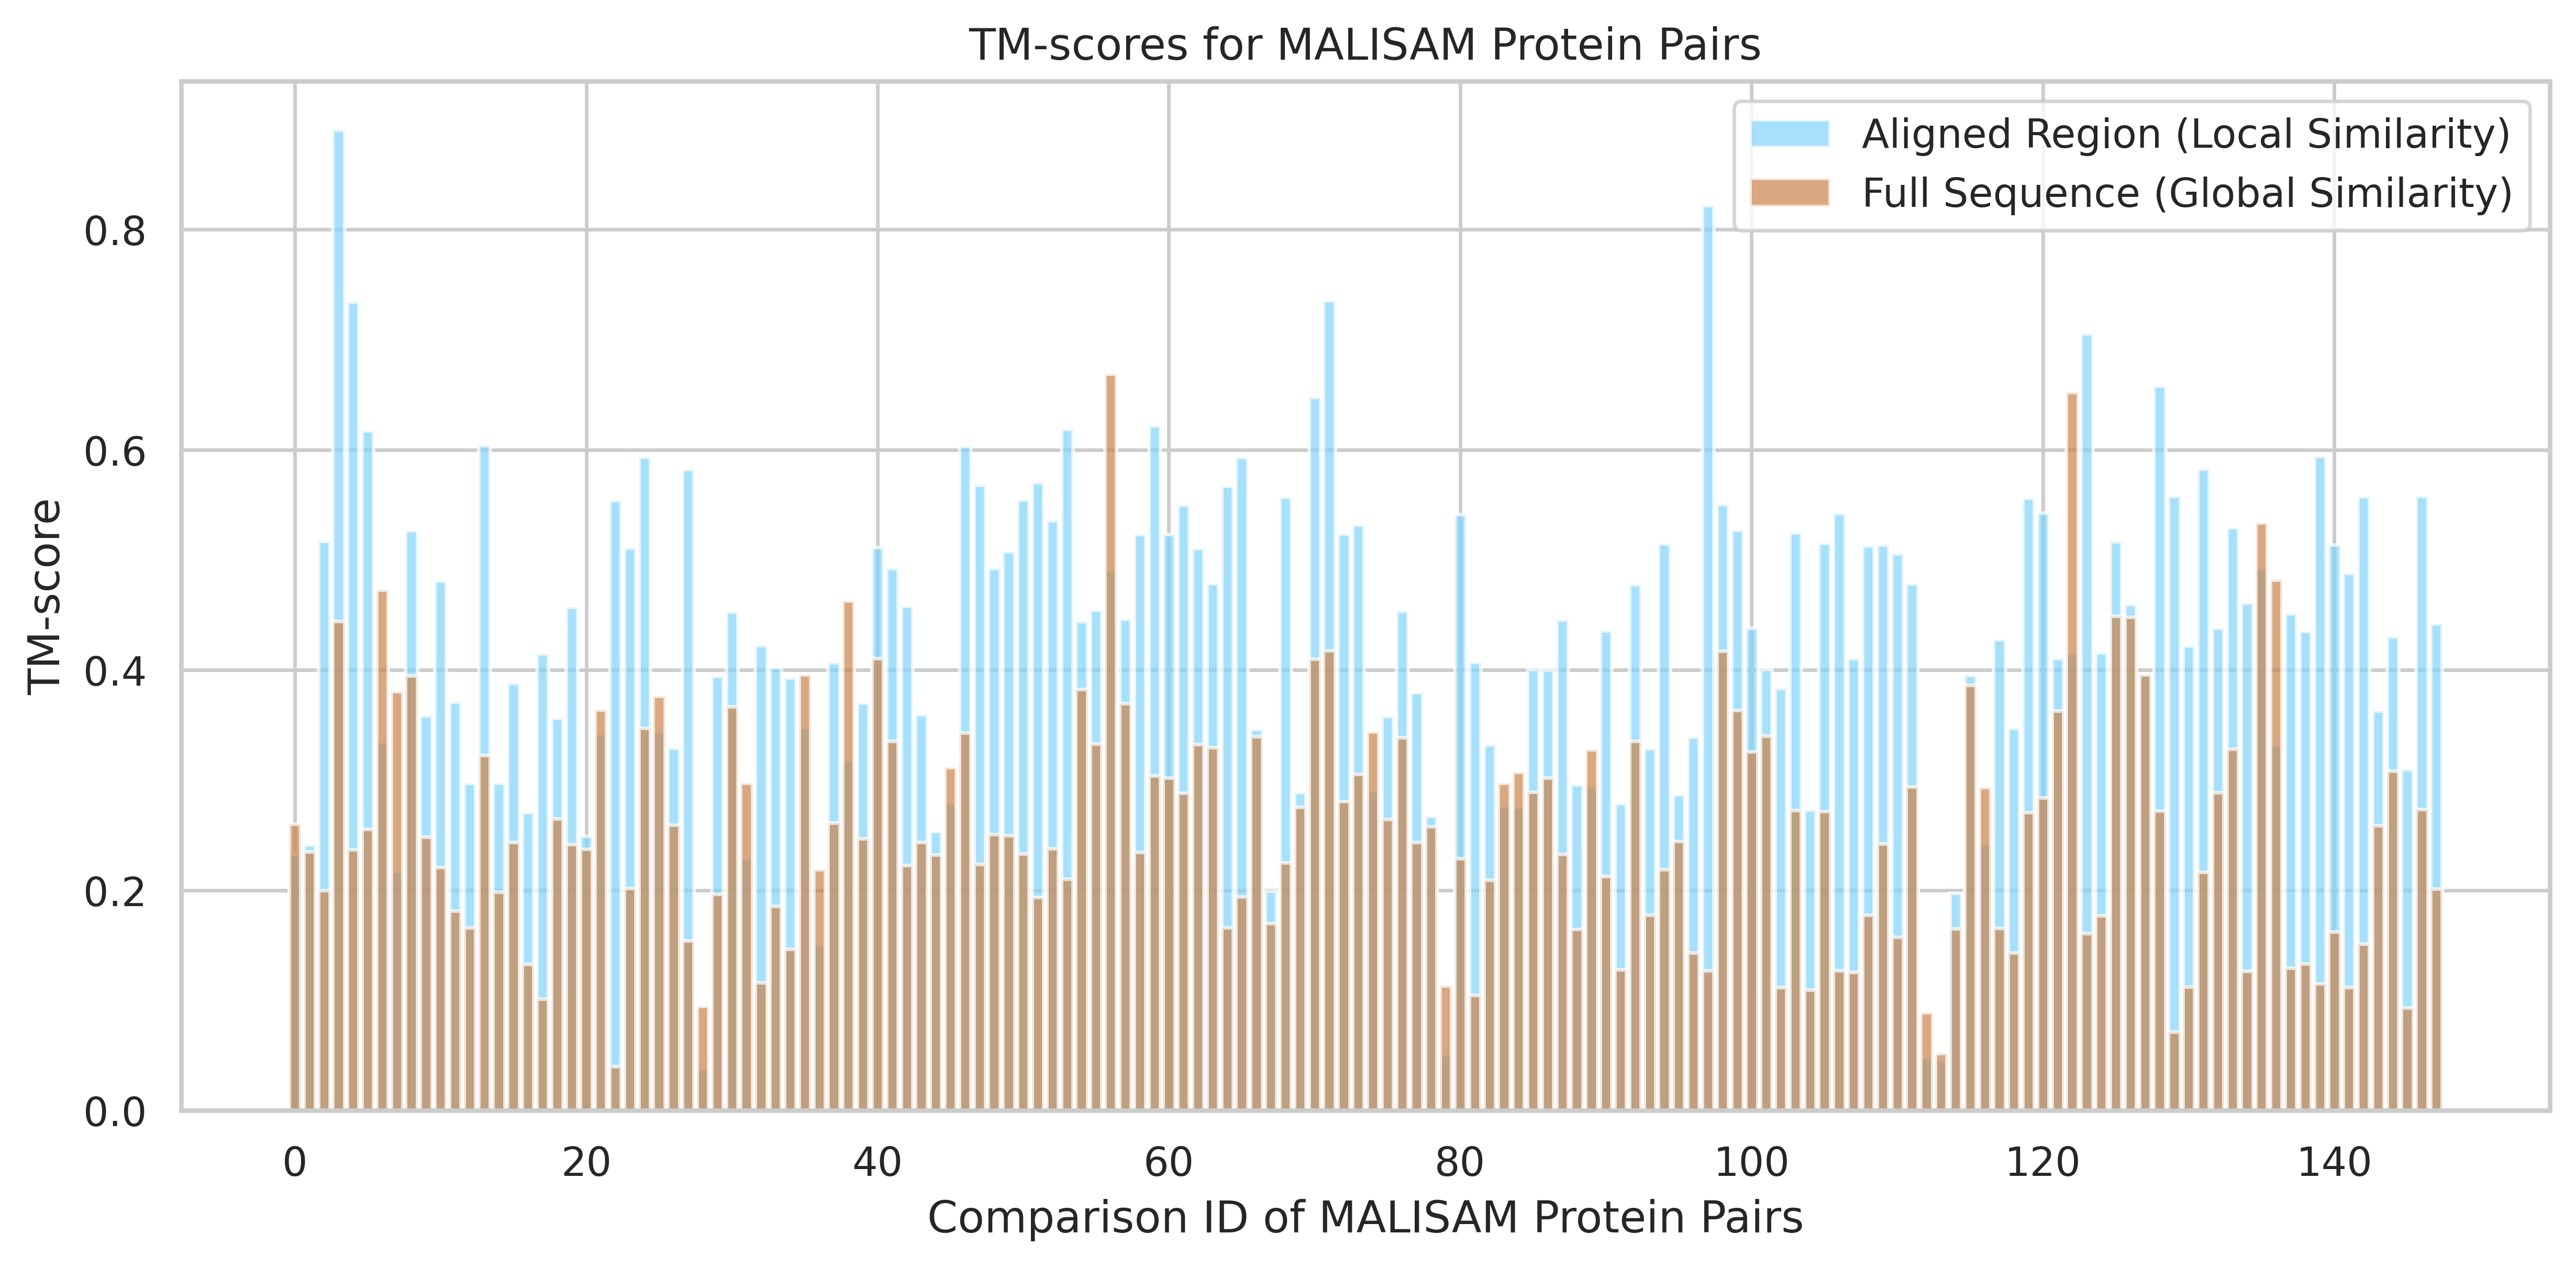

In [17]:
# bar plot of similarity scores
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5), dpi=500)
plt.bar(range(len(similarity_local_scores)), similarity_local_scores, color="#82D4FA", alpha=0.7, label='Aligned Region (Local Similarity)')
plt.bar(range(len(similarity_scores)), similarity_scores, color="#C9844B", alpha=0.7, label='Full Sequence (Global Similarity)')
plt.xlabel('Comparison ID of MALISAM Protein Pairs')
plt.ylabel('TM-score')
plt.title('TM-scores for MALISAM Protein Pairs')
plt.legend()
plt.tight_layout()
plt.show()

# ours vs theirs

In [19]:
df1 = pd.read_csv("/home/zim003/slidingwindow/mysw/prostt5_best_results.csv")
df2 = pd.read_csv("/home/zim003/slidingwindow/prostt5/prostt5_complete_results.csv")

In [20]:
id_list1 = df1["comparison_id"].tolist()
region1_list1 = df1["protein1_residues"].tolist()
region2_list1 = df1["protein2_residues"].tolist()
chain1_list1 = df1["chain1"].tolist()
chain2_list1 = df1["chain2"].tolist()
id_list2 = df2["comparison_id"].tolist()
region1_list2 = df2["protein1_residues"].tolist()
region2_list2 = df2["protein2_residues"].tolist()
chain1_list2 = df2["chain1"].tolist()
chain2_list2 = df2["chain2"].tolist()

In [21]:
similarity_local_scores1 = []

for i in tqdm(range(len(id_list1))):
    try:
        id = id_list1[i]
        region1 = eval(region1_list1[i])
        region2 = eval(region2_list1[i])
        pair_folder = os.path.join(analogs_folder, id)
        pair_paths = glob(os.path.join(pair_folder, "*.pdb"))  
        id1, id2 = id[1:5], id[8:12]
        path1, path2 = None, None
        for path in pair_paths:
            if id1 in path.split("/")[-1]:
                path1 = path
            elif id2 in path.split("/")[-1]:
                path2 = path
        similarity_local = get_similarity_score_local(path1, path2, region1, region2, chain1_list1[i], chain2_list1[i])
        similarity_local_scores1.append(similarity_local)  
    except Exception as e:
        print(f"Error processing {id}: {e}")
        continue

similarity_local_scores2 = []
for i in tqdm(range(len(id_list2))):
    try:
        id = id_list2[i]
        region1 = eval(region1_list2[i])
        region2 = eval(region2_list2[i])
        pair_folder = os.path.join(analogs_folder, id)
        pair_paths = glob(os.path.join(pair_folder, "*.pdb"))  
        id1, id2 = id[1:5], id[8:12]
        path1, path2 = None, None
        for path in pair_paths:
            if id1 in path.split("/")[-1]:
                path1 = path
            elif id2 in path.split("/")[-1]:
                path2 = path
        similarity_local = get_similarity_score_local(path1, path2, region1, region2, chain1_list2[i], chain2_list2[i])
        similarity_local_scores2.append(similarity_local)  
    except Exception as e:
        print(f"Error processing {id}: {e}")
        continue

  2%|▏         | 3/148 [00:01<01:38,  1.47it/s]/home/zim003/miniforge3/envs/process/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:208: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(
100%|██████████| 148/148 [00:53<00:00,  2.77it/s]


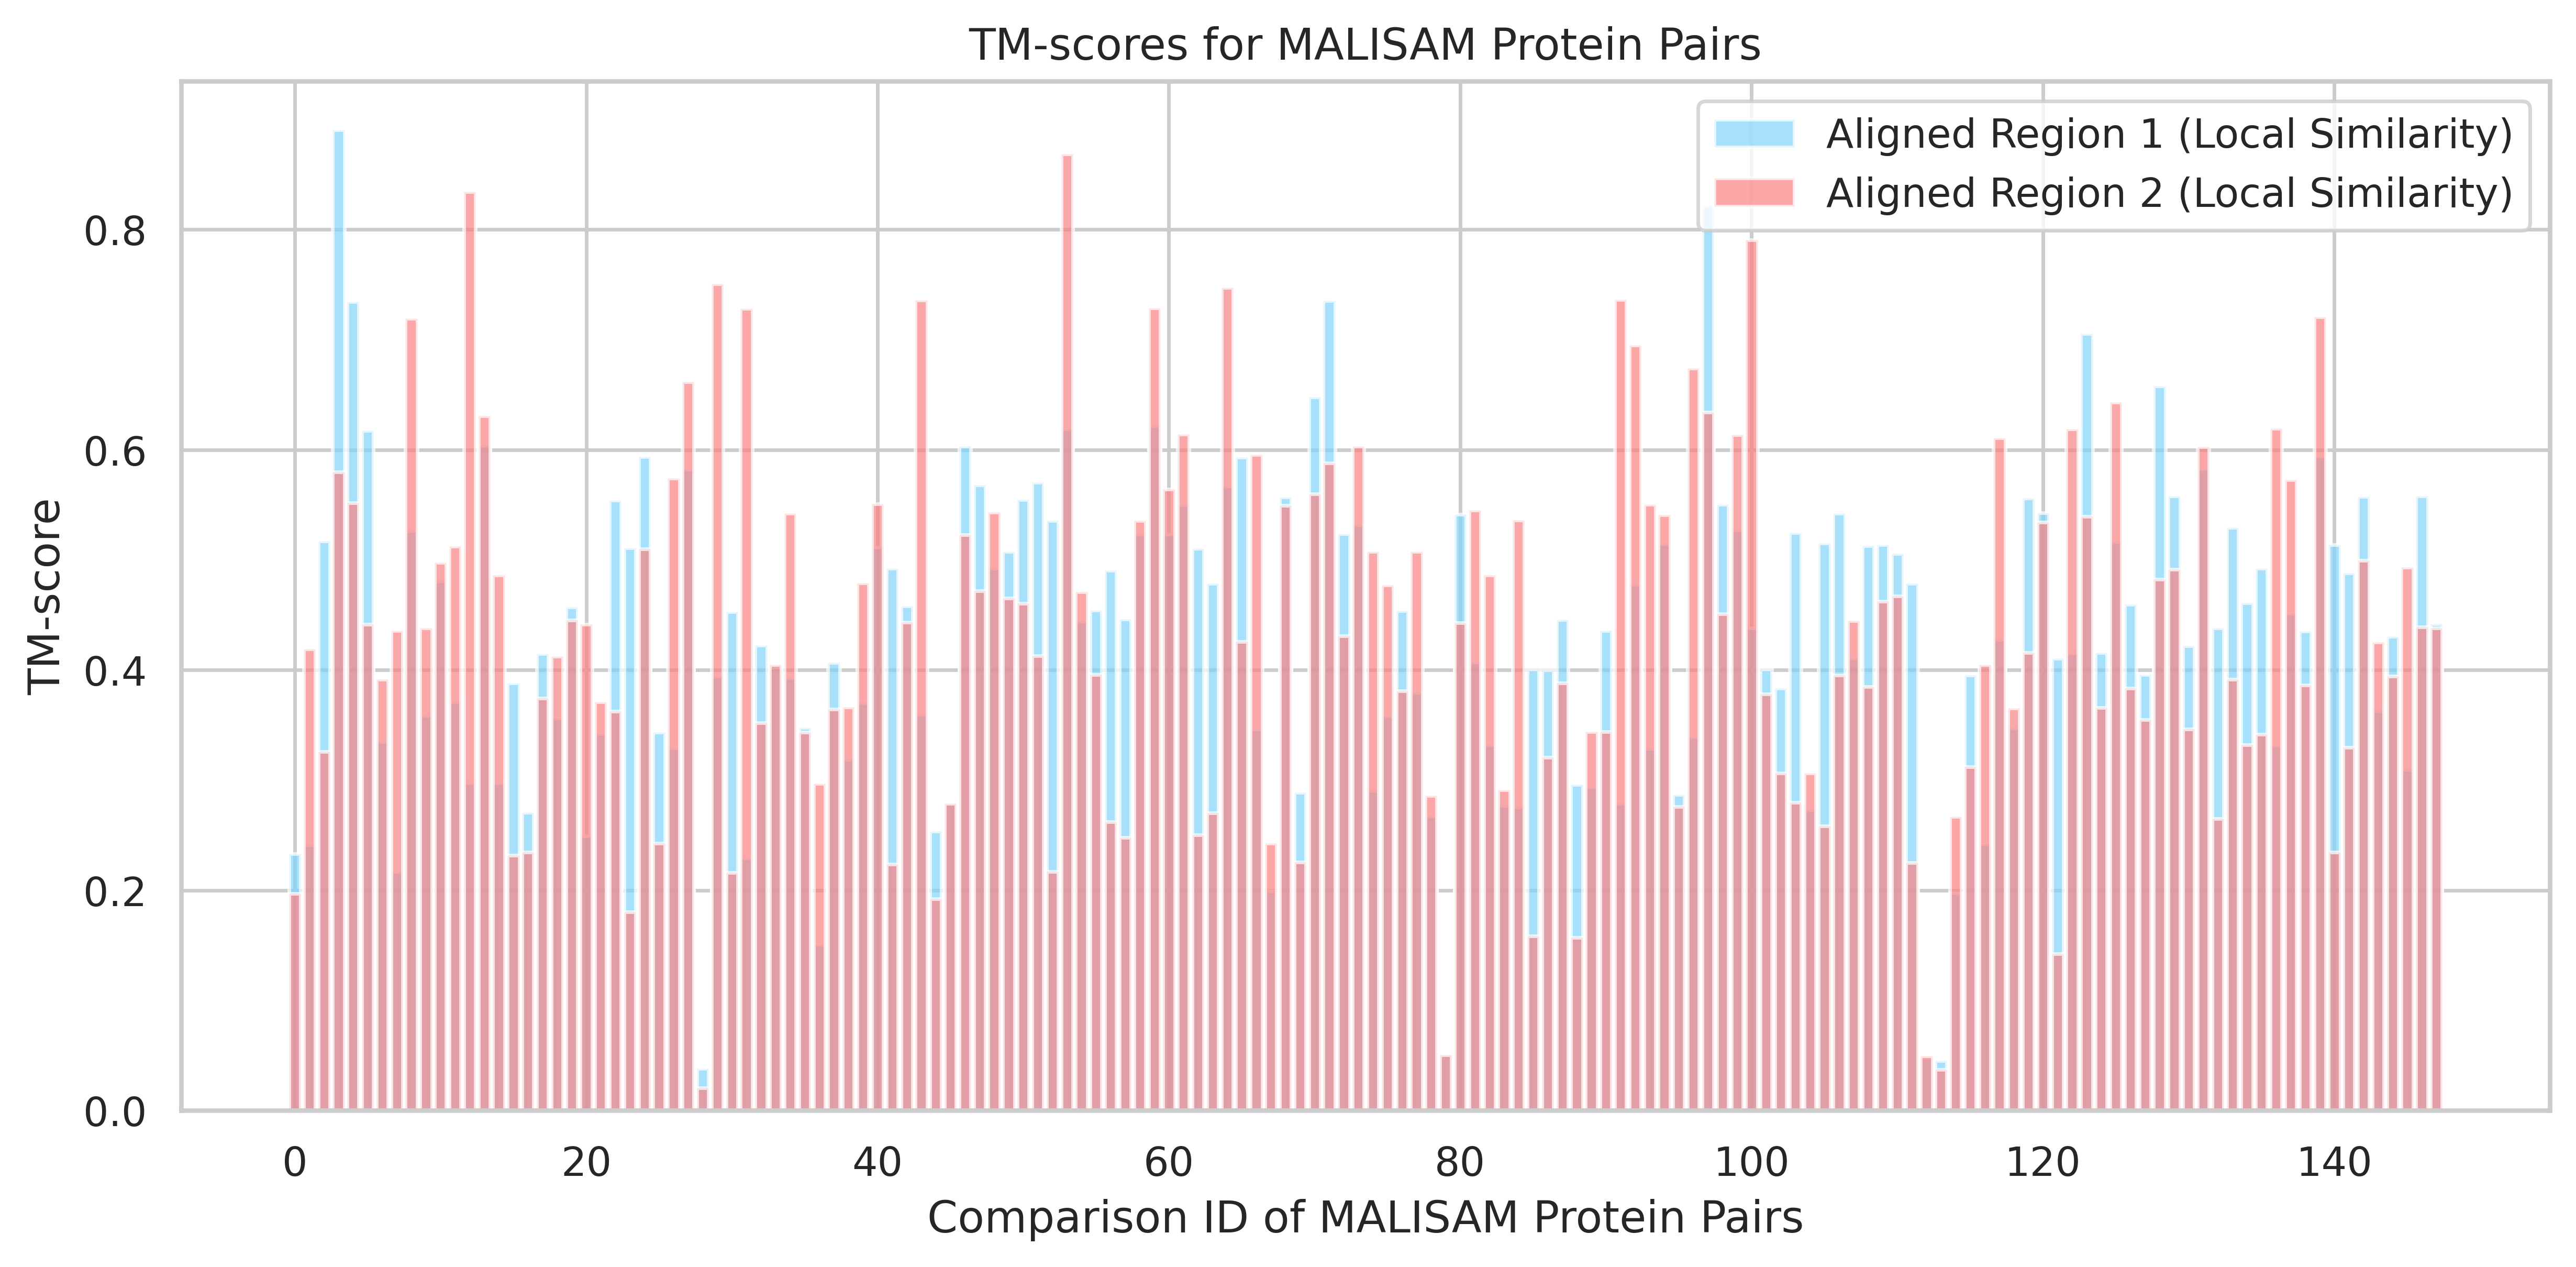

In [23]:
# bar plot of similarity scores
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5), dpi=500)
plt.bar(range(len(similarity_local_scores1)), similarity_local_scores1, color="#82D4FA", alpha=0.7, label='Aligned Region 1 (Local Similarity)')
plt.bar(range(len(similarity_local_scores2)), similarity_local_scores2, color="#FA8282", alpha=0.7, label='Aligned Region 2 (Local Similarity)')
plt.xlabel('Comparison ID of MALISAM Protein Pairs')
plt.ylabel('TM-score')
plt.title('TM-scores for MALISAM Protein Pairs')
plt.legend()
plt.tight_layout()
plt.show()